In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras_tqdm import TQDMNotebookCallback
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
benign_img_dir = '../data/ISIC/benign/images'
malignant_img_dir = '../data/ISIC/malignant/images'
benign_mask_dir = '../data/ISIC/benign/segmentation'
malignant_mask_dir = '../data/ISIC/malignant/segmentation'
img_size = (96,128)

In [3]:
X_benign = np.array(tuple([np.array(Image.open(os.path.join(benign_img_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(benign_img_dir))]))
X_malignant = np.array(tuple([np.array(Image.open(os.path.join(malignant_img_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(malignant_img_dir))]))
X = np.concatenate((X_benign,X_malignant),axis=0)

100%|██████████| 1000/1000 [01:25<00:00, 10.90it/s]


In [4]:
X_benign_mask = np.array(tuple([np.array(Image.open(os.path.join(benign_mask_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(benign_mask_dir))]))
X_malignant_mask = np.array(tuple([np.array(Image.open(os.path.join(malignant_mask_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(malignant_mask_dir))]))
X_mask = np.concatenate((X_benign_mask,X_malignant_mask),axis=0)

100%|██████████| 1000/1000 [00:20<00:00, 49.58it/s]


In [5]:
y = np.concatenate((np.zeros(len(X_benign)),np.ones(len(X_malignant))),axis=0)

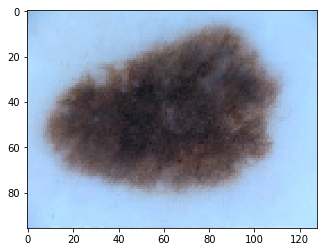

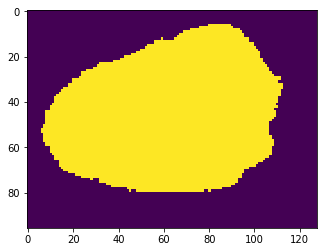

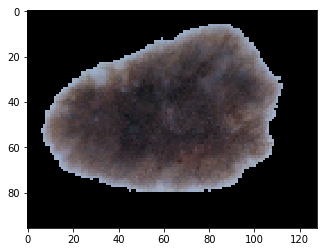

In [6]:
plt.imshow(X[0])
plt.show()

plt.imshow(X_mask[0]==255)
plt.show()

plt.imshow(X[0]*np.stack((X_mask[0]==255,X_mask[0]==255,X_mask[0]==255),axis=2))
plt.show()

In [8]:
X = X*np.stack((X_mask==255,X_mask==255,X_mask==255),axis=3)

In [9]:
X_mean, X_std = (np.mean(X,axis=(0,1,2)),np.std(X,axis=(0,1,2)))

In [10]:
print(X_mean, X_std)

[42.64222839 30.093651   25.58931368] [76.18240341 56.32338195 49.69609435]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                   test_size = 0.2, 
                                   random_state = 2018)

In [12]:
X_train_s = X_train.copy()
X_test_s = X_test.copy()
for i in range(3):
    X_train_s[:,:,:,i] = (X_train[:,:,:,i] - X_mean[i])/X_std[i]
    X_test_s[:,:,:,i] = (X_test[:,:,:,i] - X_mean[i])/X_std[i]

In [13]:
gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, shear_range=0.1, zoom_range=0.1, rotation_range=45)

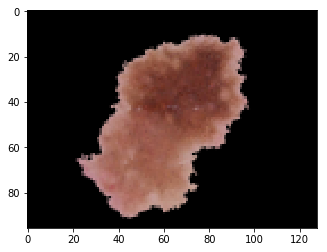

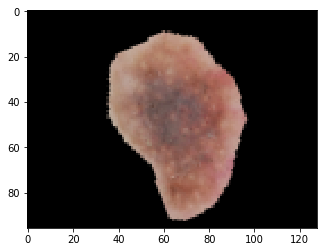

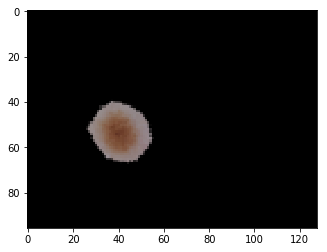

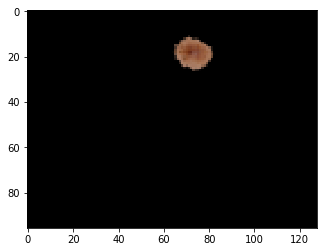

In [14]:
samples,_ = gen.flow(X_train,y_train, batch_size=4)[0]
for i in range(4):
    plt.imshow(samples[i]/255)
    plt.show()

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(*img_size,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 128, 64)       1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 32, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 32, 256)       295168    
__________

In [16]:
model_path = '../models/CNN_binary_v1.h5'

In [17]:
model.compile('sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(restore_best_weights = True, patience = 5),
            keras.callbacks.ModelCheckpoint(model_path,save_best_only=True),
            TQDMNotebookCallback()]

In [18]:
batch_size = 64

In [19]:
history = model.fit_generator(
    gen.flow(X_train_s,y_train, batch_size=batch_size),epochs=30,
    callbacks = callbacks,
    validation_data=(X_test_s,y_test),
    workers=6,
    steps_per_epoch = len(X_train)//batch_size,
    verbose=0)

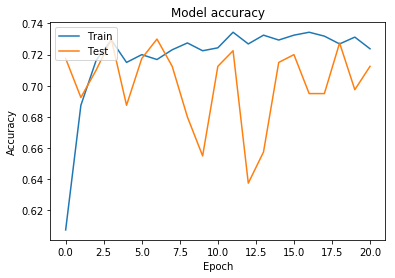

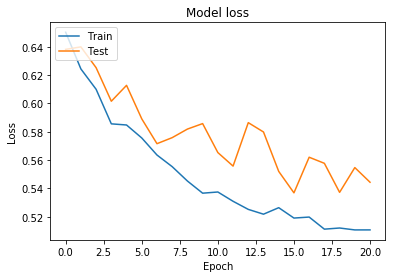

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
pd.DataFrame(history.history)

,val_loss,val_acc,loss,acc
0,0.638132,0.7175,0.650218,0.607500
1,0.639878,0.6925,0.624317,0.687500
2,0.625200,0.7100,0.609962,0.716250
3,0.601520,0.7300,0.585554,0.729375
4,0.612729,0.6875,0.584745,0.715000
5,0.589077,0.7175,0.575586,0.720000
6,0.571551,0.7300,0.563548,0.716875
7,0.575814,0.7125,0.555326,0.723125
8,0.581858,0.6800,0.545195,0.727500
9,0.585728,0.6550,0.536608,0.722500


In [22]:
model = keras.models.load_model(model_path)

In [23]:
y_pred = model.predict_classes(X_test_s)

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73       197
         1.0       0.74      0.68      0.71       203

   micro avg       0.72      0.72      0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400

